# Libraries

In [1]:
from __future__ import print_function

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import psutil
import time
import pickle
import gc
import tracemalloc

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# XNOR-net model
as it is available at https://github.com/jiecaoyu/XNOR-Net-PyTorch/tree/master/MNIST

In [2]:
class BinActive(torch.autograd.Function):
    '''
    Binarize the input activations and calculate the mean across channel dimension.
    '''

    @staticmethod
    def forward(ctx, inputs):
        ctx.save_for_backward(inputs)  # save inputs
        size = inputs.size()
        input = inputs.sign()  # signum(input)
        return input

    # --> sign of the input (vector of 1s, -1s)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors  # retrieve saved inputs
        grad_input = grad_output.clone()
        grad_input[input.ge(1)] = 0  # >=
        grad_input[input.le(-1)] = 0  # <=
        return grad_input

    # --> gradient over the inputs

    

''' this is the manifacturing of a brand new Binary Convolutional Layer '''


class BinConv2d(nn.Module):  # change the name of BinConv2d
    def __init__(self, input_channels, output_channels,
                 kernel_size=-1, stride=-1, padding=-1, groups=1, dropout=0,
                 Linear=False, previous_conv=False, size=0, act_function=nn.ReLU(), 
                 act_final=True, batchnorm=True):
        super(BinConv2d, self).__init__()
        self.input_channels = input_channels
        self.layer_type = 'BinConv2d'  
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dropout_ratio = dropout
        self.previous_conv = previous_conv

        if dropout != 0:
            self.dropout = nn.Dropout(dropout)

        self.Linear = Linear

        # convolutional layers
        if not self.Linear:
            if batchnorm:
                self.bn = nn.BatchNorm2d(input_channels, eps=1e-4, momentum=0.1, affine=True)  # batch normalization
            else:
                self.bn = nn.Identity()
            self.conv = nn.Conv2d(input_channels, output_channels,
                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)

        # linear layers
        else:
            if self.previous_conv:
                self.bn = nn.BatchNorm2d(int(input_channels / size), eps=1e-4, momentum=0.1, affine=True)
            elif batchnorm:
                self.bn = nn.BatchNorm1d(input_channels, eps=1e-4, momentum=0.1, affine=True)
            else:
                self.bn = nn.Identity()
            self.linear = nn.Linear(input_channels, output_channels)

        if act_final:
            self.relu = act_function
        else:
            self.relu = nn.Identity()

    @staticmethod
    def forward(x, bn, dropout_ratio, dropout, Linear, conv, previous_conv, input_channels, linear, relu):
        x = bn(x)  # batch normalization
        x = BinActive.apply(x)  # binarize the input
        
        if dropout_ratio != 0:
            x = dropout(x)

        if not Linear:
            x = conv(x)  # through its convolution
        else:
            if previous_conv:
                x = x.view(x.size(0), input_channels)
            x = linear(x)  # through its linear layer
        
        x = relu(x)
    
        return x


''' 
architecture:

    - Conv, bn, relu, mpool
    - BConv, mpool
    - BConv
    - Linear

'''

class LeNet_5(nn.Module):
    def __init__(self, act_func):
        super(LeNet_5, self).__init__()

        self.conv1 = nn.Conv2d(1, 20, kernel_size=5,
                               stride=1)  
        self.bn_conv1 = nn.BatchNorm2d(20, eps=1e-4, momentum=0.1, affine=False)
        self.relu_conv1 = act_func
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bin_conv2 = BinConv2d(20, 50, kernel_size=5, stride=1,
                                   padding=0, dropout=0, act_function=act_func)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bin_ip1 = BinConv2d(50 * 4 * 4, 500, Linear=True, 
                                 previous_conv=True, size=4 * 4, act_function=act_func)

        self.ip2 = nn.Linear(500, 10)  

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if hasattr(m.weight, 'data'):
                    m.weight.data.zero_().add_(1.0)
        return

    @staticmethod
    def forward(x, modules, conv1, bn_conv1, relu_conv1, pool1, bin_conv2, pool2, bin_ip1, ip2):
        for m in modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if hasattr(m.weight, 'data'):
                    m.weight.data.clamp_(min=0.01)

        x = conv1(x)
        x = bn_conv1(x)
        x = relu_conv1(x)
        x = pool1(x)
        x = bin_conv2.forward(x, bn=bin_conv2.bn, dropout_ratio=bin_conv2.dropout_ratio, dropout=0,
                              Linear=bin_conv2.Linear, conv=bin_conv2.conv, previous_conv=bin_conv2.previous_conv,
                              input_channels=bin_conv2.input_channels, linear=0, relu=bin_conv2.relu)
        x = pool2(x)

        # x = x.view(x.size(0), 50*4*4)
        x = bin_ip1(x, bn=bin_ip1.bn, dropout_ratio=bin_ip1.dropout_ratio, dropout=0,
                    Linear=bin_ip1.Linear, conv=0, previous_conv=bin_ip1.previous_conv,
                    input_channels=bin_ip1.input_channels, linear=bin_ip1.linear, relu=bin_ip1.relu)
        x = ip2(x)

        return x


class BinOp():
    def __init__(self, model):
        # count the number of Conv2d and Linear
        count_targets = 0
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                count_targets = count_targets + 1  # count the number of layers

        start_range = 1
        end_range = count_targets - 2
        self.bin_range = numpy.linspace(start_range,
                                        end_range, end_range - start_range + 1) \
            .astype('int').tolist()
        self.num_of_params = len(self.bin_range)
        self.saved_params = []
        self.target_modules = []
        index = -1
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):  # save the parameters of the target layers
                index = index + 1
                if index in self.bin_range:
                    tmp = m.weight.data.clone()
                    self.saved_params.append(tmp)
                    self.target_modules.append(m.weight)
        return

    def binarization(self):
        self.meancenterConvParams()
        self.clampConvParams()
        self.save_params()
        self.binarizeConvParams()

    def meancenterConvParams(self):
        for index in range(self.num_of_params):
            s = self.target_modules[index].data.size()  # size of the layer
            negMean = self.target_modules[index].data.mean(1, keepdim=True). \
                mul(-1).expand_as(self.target_modules[index].data)  # vector with the negative mean
            self.target_modules[index].data = self.target_modules[index].data.add(negMean)  # application to the layer

    def clampConvParams(self):  # clipping
        for index in range(self.num_of_params):
            self.target_modules[index].data = \
                self.target_modules[index].data.clamp(-1.0, 1.0)

    def save_params(self):  # save the mean centered real-clipped parameters
        for index in range(self.num_of_params):
            self.saved_params[index].copy_(self.target_modules[index].data)

    def binarizeConvParams(self):  # normalize and binarize
        for index in range(self.num_of_params):
            n = self.target_modules[index].data[0].nelement()
            s = self.target_modules[index].data.size()
            if len(s) == 4:
                m = self.target_modules[index].data.norm(1, 3, keepdim=True) \
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n)
            elif len(s) == 2:
                m = self.target_modules[index].data.norm(1, 1, keepdim=True).div(n)
            self.target_modules[index].data = self.target_modules[index].data.sign().mul(m.expand(s))

    def restore(self):
        for index in range(self.num_of_params):
            self.target_modules[index].data.copy_(self.saved_params[index])

    def updateBinaryGradWeight(self):
        ''' 
        this correspond to the gradient manipulation:
        - clipping in (-1, +1)
        - backward BatchNormalization()
        '''
        for index in range(self.num_of_params):
            weight = self.target_modules[index].data
            n = weight[0].nelement()
            s = weight.size()

            # normalize -> weight norm (wnorm)
            if len(s) == 4:
                m = weight.norm(1, 3, keepdim=True) \
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)
            elif len(s) == 2:
                m = weight.norm(1, 1, keepdim=True).div(n).expand(s)

            # clip wnorm
            m[weight.lt(-1.0)] = 0
            m[weight.gt(1.0)] = 0

            # multiply wnorm by the gradient
            m = m.mul(self.target_modules[index].grad.data)

            # multiply the sign of the weights by the gradient -> signed grad vect
            m_add = weight.sign().mul(self.target_modules[index].grad.data)

            # sum grad vect
            if len(s) == 4:
                m_add = m_add.sum(3, keepdim=True) \
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)  # div: divide the tensor by args, expand: reshape
            elif len(s) == 2:
                m_add = m_add.sum(1, keepdim=True).div(n).expand(s)

            # mutiply sum grad vect by the weight sign
            m_add = m_add.mul(weight.sign())
            self.target_modules[index].grad.data = m.add(m_add).mul(1.0 - 1.0 / s[1]).mul(n)



**TRAINING** & **TESTING**

this part it is not actually used in the following sections, but it might be handy if needed

In [3]:
def train(net, epoch):
    net.model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        # input batch loading
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        net.optimizer.zero_grad()

        # process the weights including binarization
        net.bin_op.binarization()

        # forward
        output = net.model.forward(x=data, modules=net.model.modules, conv1=net.model.conv1, bn_conv1=net.model.bn_conv1,
                               relu_conv1=net.model.relu_conv1, pool1=net.model.pool1, bin_conv2=net.model.bin_conv2,
                               pool2=net.model.pool2, bin_ip1=net.model.bin_ip1, ip2=net.model.ip2)

        # backward
        loss = net.criterion(output, target)
        loss.backward()

        # restore weights
        net.bin_op.restore()

        # update
        net.bin_op.updateBinaryGradWeight()

        net.optimizer.step()
        
    return net, numpy.around(loss.data.item(), 3)


def test(net, evaluate=False):
    global best_acc
    with torch.no_grad():
        test_loss = 0
        correct = 0

        net.bin_op.binarization()
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = net.model.forward(data, net.model.modules, net.model.conv1, net.model.bn_conv1, net.model.relu_conv1, net.model.pool1,
                                     net.model.bin_conv2, net.model.pool2, net.model.bin_ip1, net.model.ip2)
            test_loss += net.criterion(output, target).data.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        net.bin_op.restore()

        best_acc = 100. * float(correct) / len(test_loader.dataset)
      
    test_loss /= len(test_loader.dataset)
    
    return best_acc


def adjust_learning_rate(net, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 15 epochs"""
    net.lr = net.lr * (0.1 ** (epoch // lr_epochs))
    #print('Learning rate:', lr)
    for param_group in net.optimizer.param_groups:
        param_group['lr'] = net.lr
    return net



#### **GENERAL SETTINGS** & dataset Loading

In [4]:
# Training settings

# elaborated way for asking parameters input from the user and the handle the arguments

batch_size = 128
test_batch_size = 128
lr_epochs = 15
lr = 0.01
momentum = 0.9
weight_decay = 1e-5
no_cuda = False
seed = 1
log_interval = 100
arch = 'LeNet_5'
pretrained = None
evaluate = False
cuda = torch.cuda.is_available()

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

# load data
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## EVALUATING ACTIVATION FUNCTIONS

in this part, the LeNet-5 XNOR-net is run with different activation functions, so to have a comparison.
Different metrics are used:
- accuracy 
- time
- memory consumption

###**Model**

In [6]:
class Model:
    
    ''' this is the network that comprehends LeNet5 and attributes to help training '''
    
    def __init__(self, act_fun=nn.ReLU()):
        
        # model
        self.model = LeNet_5(act_func=act_fun)
        self.model.cuda()
        
        param_dict = dict(self.model.named_parameters())
        params = []
    
        # learning rate
        base_lr = 0.1
        self.lr = lr
    
        for key, value in param_dict.items():
            params += [{'params':[value], 'lr': lr,
                'weight_decay': weight_decay,
                'key':key}]

        # define optimization
        base_lr = 0.1
        self.optimizer = optim.Adam(params, lr=lr,
                            weight_decay=weight_decay)
        self.criterion = nn.CrossEntropyLoss()
        
        # define the binarization operator
        self.bin_op = BinOp(self.model)

    def training(self):
        self.model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            # input batch loading
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            self.optimizer.zero_grad()

            # process the weights including binarization
            self.bin_op.binarization()

            # forward
            output = self.model.forward(x=data, modules=self.model.modules, conv1=self.model.conv1, bn_conv1=self.model.bn_conv1,
                                relu_conv1=self.model.relu_conv1, pool1=self.model.pool1, bin_conv2=self.model.bin_conv2,
                                pool2=self.model.pool2, bin_ip1=self.model.bin_ip1, ip2=self.model.ip2)

            # backward
            loss = self.criterion(output, target)
            loss.backward()

            # restore weights
            self.bin_op.restore()

            # update
            self.bin_op.updateBinaryGradWeight()

            self.optimizer.step()

        return numpy.around(loss.data.item(), 3)


    def test(self, rec=False):
        
        # rec: measure time and memory
        if rec:
            with torch.no_grad():
                test_loss = 0
                correct = 0
                
                self.bin_op.binarization()
                t0 = time.time()
                tracemalloc.start()
                
                for data, target in test_loader:
                    if cuda:
                        data, target = data.cuda(), target.cuda()
                    data, target = Variable(data), Variable(target)
                    output = self.model.forward(data, self.model.modules, self.model.conv1, self.model.bn_conv1, self.model.relu_conv1, self.model.pool1,
                                            self.model.bin_conv2, self.model.pool2, self.model.bin_ip1, self.model.ip2)
                    test_loss += self.criterion(output, target).data.item()
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                tim_used = time.time() - t0
                
                # self.bin_op.restore()
                best_acc = 100. * float(correct) / len(test_loader.dataset)
        
            test_loss /= len(test_loader.dataset)
            
        
            return best_acc, current/1024/1024, tim_used
  
        # simple test, without measuring anything other that accuracy
        with torch.no_grad():
            test_loss = 0
            correct = 0

            self.bin_op.binarization()
            for data, target in test_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                output = self.model.forward(data, self.model.modules, self.model.conv1, self.model.bn_conv1, self.model.relu_conv1, self.model.pool1,
                                        self.model.bin_conv2, self.model.pool2, self.model.bin_ip1, self.model.ip2)
                test_loss += self.criterion(output, target).data.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            self.bin_op.restore()

            best_acc = 100. * float(correct) / len(test_loader.dataset)
        
        test_loss /= len(test_loader.dataset)
        
        return best_acc
    
    
    def long_test(self):
        '''
        a test run over the training dataset, so to have a bigger image set. The accuracy will inherently be biased,
        but the measure of time and memory might provide more insightful results.
        '''
        
        with torch.no_grad():
            test_loss = 0
            correct = 0

            self.bin_op.binarization()
            t0 = time.time()
            tracemalloc.start()

            for data, target in train_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                output = self.model.forward(data, self.model.modules, self.model.conv1, self.model.bn_conv1, self.model.relu_conv1, self.model.pool1,
                                        self.model.bin_conv2, self.model.pool2, self.model.bin_ip1, self.model.ip2)
                test_loss += self.criterion(output, target).data.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            tim_used = time.time() - t0

            # self.bin_op.restore()
            best_acc = 100. * float(correct) / len(test_loader.dataset)

        test_loss /= len(test_loader.dataset)


        return current/1024/1024, tim_used
  

    def adjust_learning_rate(self, epoch):
        """Sets the learning rate to the initial LR decayed by 10 every 15 epochs"""
        
        self.lr = self.lr * (0.1 ** (epoch // lr_epochs))
        #print('Learning rate:', lr)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr




def generate(act_function, verbose=False):
    '''
    compact run, get an activation function, build a model with it and run it
    '''
  
    name = str(act_function)[:-2]
    network = Model(act_fun=act_function)

    # start measure
    process = psutil.Process(os.getpid())
    mem0 = process.memory_info().rss 
    time0 = time.time()

    # logs
    best_acc = 0.0
    accs = []
    losses = []

    # run
    print(f'# ready to train {name} for {epochs} epochs#\n')
    for epoch in range(1, epochs + 1):

        network.adjust_learning_rate(epoch)
        loss_ = network.training()
        acc_ = network.test()

        # state
        accs.append(acc_)
        losses.append(loss_)


        if verbose:
            # plots
            plt.clf()
            plt.figure(figsize=(20, 6))

            plt.subplot(121)
            plt.axhline(y=100.0, linestyle='--', color='grey')
            plt.plot(range(epoch), accs, label=f'accuracy {accs[-1]}')
            plt.title('Test Accuracy  - type: {} - epoch {}|{}'.format(name, epoch, epochs))
            plt.legend()
            plt.xlabel('epochs')
            plt.ylabel('%')
            plt.xlim((0, epochs-1))
            plt.ylim((80, 110))

            plt.subplot(122)
            plt.plot(range(epoch), losses, label=f'loss {losses[-1]}')
            plt.title('loss')
            plt.xlabel('epochs')
            plt.legend()
            plt.xlim((0, epochs-1))

            plt.pause(0.000001)

            if is_ipython: display.clear_output(wait=True)
        else:
            print('type: {} - epoch {}|{}'.format(name, epoch, epochs))
            if is_ipython: display.clear_output(wait=True)


    # end measure
    process = psutil.Process(os.getpid())
    memU = process.memory_info().rss - mem0
    timeU = time.time() - time0


    return {'name': str(act_function)[:-2],
            'acc': accs[-1],
            'memory': memU,
            'time': timeU}

###**RUN**

In [ ]:
# activation functions to try
act_func1 = (nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.ELU(), nn.Hardsigmoid(), nn.LeakyReLU(), nn.SELU(), nn.CELU(), nn.GELU())

results = {}

epochs = 2
for i, f in enumerate(act_func1):
    results[i] = generate(act_function=f)

print('\nfinished')

type: GELU - epoch 2|2


Collect and organize the results from all the runs 

In [ ]:
all_acc = []
all_mem = []
all_time = []
names = []

for j in range(len(act_func1)):
    name_ = results[j]['name']
    if name_.__len__() > 8:
        names.append(name_[:9])
    else:
        names.append(name_)
        
    all_acc.append(results[j]['acc'])
    all_mem.append(results[j]['memory'])
    all_time.append(results[j]['time'])

Plotting

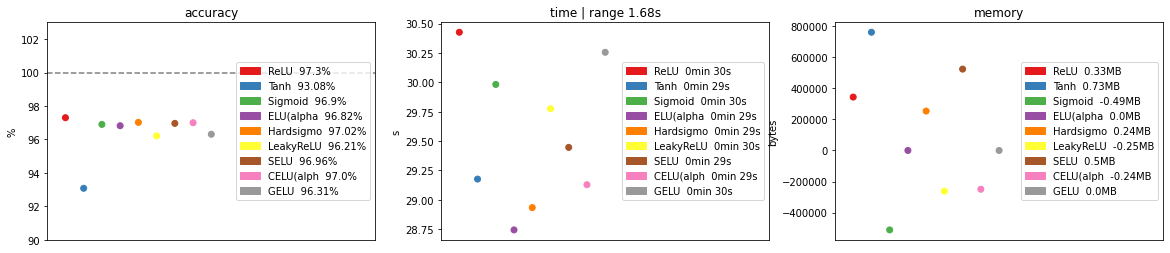

In [ ]:
n = len(all_acc)
x = range(n)

cols = plt.cm.Set1(numpy.linspace(0, 1, n))

plt.figure(figsize=(20, 4))

# accuracy
plt.subplot(131)
plt.axhline(y=100.0, linestyle='--', color='grey')
plt.scatter(x, all_acc, c=x, cmap='Set1')
plt.xticks(())
plt.ylabel('%')
plt.ylim((90, 103))
plt.title('accuracy')
plt.xlim((-1, n+8))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(all_acc[h], 3))+'%'))
plt.legend(loc='right', handles=patches)


# time
plt.subplot(132)
plt.scatter(x, all_time, c=x, cmap='Set1')
plt.xticks(())

plt.ylabel('s')
plt.xlim((-1, n+8))

patches = []
for h, name in enumerate(names):
    min = round(all_time[h]//60)
    sec = round(all_time[h]%60)
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(min)+'min '+str(sec)+'s'))
plt.legend(loc='right', handles=patches)
plt.title('time | range {}s'.format(numpy.around(max(all_time)-numpy.min(all_time), 2)))

# memory
plt.subplot(133)
plt.scatter(x, all_mem, c=x, cmap='Set1')
plt.xticks(())
plt.title('memory')
plt.ylabel('bytes')
plt.xlim((-1, n+8))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(all_mem[h]/1048576, 2))+'MB'))
plt.legend(loc='right', handles=patches);

### More rounds!
each activation function is used k times, but their order is random and their results averaged over k. The idea is to get rid of the random variations that could occur during the whole process (mainly because it isn't guaranteed the uniformity and independence of the cloud computing service (colab)). 

In [7]:
## adjust compact run function
def generate2(act_fu):
  
    # model
    name = str(act_fu)[:-2]
    network = Model(act_fun=act_fu)

    # logs
    best_acc = 0.0
    accs = []
    losses = []
    
    #start measure 
    gc.collect()
    time0 = time.time()
    tracemalloc.start()
    
    # run
    for epoch in range(1, epochs + 1):

        network.adjust_learning_rate(epoch)
        loss_ = network.training()
        acc_ = network.test()

        # logs
        accs.append(acc_)
        losses.append(loss_)

    # end measure
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    timeU = time.time() - time0

    # accuracies
    a, m, t = network.test(rec=True)
    m2, t2 = network.long_test()
    
    net = network.model
    network.bin_op.binarization()

    # return: train accuracy, train memory used in KB, train time used, 
    #         test accuracy,  test memory used, test time used, 
    #                         long test memory used, long test time used
    return accs[-1], current/1024/1024, timeU, a, m, t, m2, t2


**RUN script**

In [8]:
# simulation parameters
repetition = 0  # of each activation function
epochs = 2

# activation functions (comment out the sequence you do not want)
# long seq
#act_func1 = (nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.ELU(), nn.Hardsigmoid(), nn.LeakyReLU(), nn.SELU(), nn.CELU(), nn.GELU())
#names = ('ReLU', 'Tanh', 'Sigmoid', 'ELU', 'HardSig', 'LeakyReLU', 'SELU', 'CELU', 'GELU')

# short seq
act_func1 = (nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.Hardsigmoid(), nn.LeakyReLU(), nn.GELU())
names = ('ReLU', 'Tanh', 'Sigmoid', 'HardSig', 'LeakyReLU', 'GELU')

# tot
n = act_func1.__len__()

# dictionary describing the results obtained from each element
func_dict = {}
for j, name in enumerate(act_func1):
    func_dict[j] = {'name': str(name),
                    'func': name,
                    'acc': [],
                    'memory': [], 
                    'time': []}

# defining the order
order = numpy.arange(act_func1.__len__())
order_plus = numpy.random.choice(order, size=n, replace=False)
for _ in range(repetition):
    order_plus = numpy.concatenate((order_plus, numpy.random.choice(order, size=n, replace=False)))
numpy.random.shuffle(order_plus)
print('order of the activation functions: ', order_plus)

# run
for i, k in enumerate(order_plus):
    print(f'{i+1}|{order_plus.__len__()}, completed: {round(i/order_plus.__len__()*100)}%')
    
    # select
    func = func_dict[k]['func']

    # run
    a, m, t, _, _, _, _, _ = generate2(act_fu=func)

    #store
    func_dict[k]['acc'].append(a)
    func_dict[k]['memory'].append(m)
    func_dict[k]['time'].append(t)

print('\nprocess terminated')

order of the activation functions:  [1 0 2 4 3 5]
1|6, completed: 0%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)


2|6, completed: 17%
3|6, completed: 33%
4|6, completed: 50%
5|6, completed: 67%
6|6, completed: 83%

process terminated


Processing the results

In [9]:
results = {'acc': [],
           'memory': [],
           'time': []}

for j in order:
    for feature in ('acc', 'memory', 'time'):
        func_dict[j][feature] = numpy.mean(func_dict[j][feature])
        results[feature].append(func_dict[j][feature])


Plotting

Average results obtained for 1 repetition lasting 2 epochs


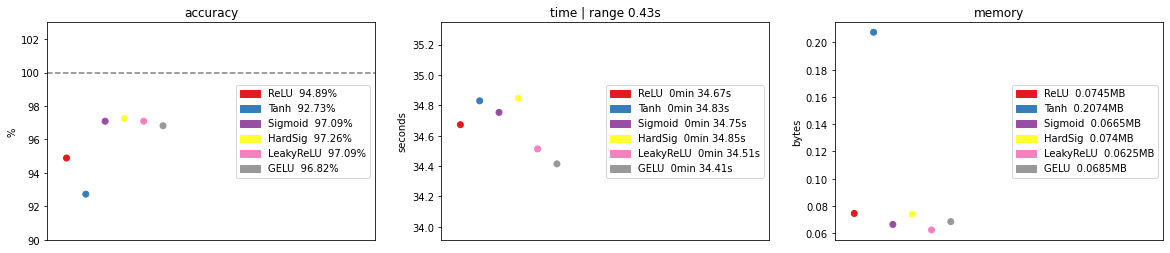

In [10]:
print(f'Average results obtained for {repetition+1} repetition lasting {epochs} epochs')

all_acc, all_time, all_mem = results['acc'], results['time'], results['memory']

n = names.__len__()
x = range(n)

cols = plt.cm.Set1(numpy.linspace(0, 1, n))

plt.figure(figsize=(20, 4))
detached = 10

# accuracy
plt.subplot(131)
plt.axhline(y=100.0, linestyle='--', color='grey')
plt.scatter(x, all_acc, c=x, cmap='Set1')
plt.xticks(())
plt.ylabel('%')
plt.ylim((90, 103))
plt.title('accuracy')
plt.xlim((-1, n+detached))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(all_acc[h], 2))+'%'))
plt.legend(loc='right', handles=patches)


# time
plt.subplot(132)
plt.scatter(x, all_time, c=x, cmap='Set1')
plt.xticks(())

plt.ylabel('seconds')
plt.xlim((-1, n+detached))
plt.ylim((numpy.min(all_time)-0.5, max(all_time)+0.5))

patches = []
for h, name in enumerate(names):
    min = round(all_time[h]//60)
    sec = numpy.around(all_time[h]%60, 2)
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(min)+'min '+str(sec)+'s'))
plt.legend(loc='right', handles=patches)
plt.title('time | range {}s'.format(numpy.around(max(all_time)-numpy.min(all_time), 2)))

# memory
plt.subplot(133)
plt.scatter(x, all_mem, c=x, cmap='Set1')
plt.xticks(())
plt.title('memory')
plt.ylabel('bytes')
plt.xlim((-1, n+detached))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(all_mem[h], 4))+'MB'))
plt.legend(loc='right', handles=patches);

# NETWORK 2: *Standard CNN* 
it has the same layout as LeNet_5, only not binary

In [ ]:
class CNN_standard(nn.Module):
    def __init__(self, act_func):
        super().__init__()

        # block 1
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1) 
        self.bn_conv1 = nn.BatchNorm2d(20, eps=1e-4, momentum=0.1, affine=False)
        self.relu_conv1 = act_func
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
  
        # block 2
        self.bn_conv2 = nn.BatchNorm2d(20, eps=1e-4, momentum=0.1, affine=True)  # batch normalization
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=0)
        self.relu_conv2 = act_func
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # block 3
        self.bn_ip1 = nn.BatchNorm2d(50, eps=1e-4, momentum=0.1, affine=True)
        self.ip1 = nn.Linear(50 * 4 * 4, 500)
        self.relu_ip1 = act_func

        # output
        self.ip2 = nn.Linear(500, 10) 

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if hasattr(m.weight, 'data'):
                    m.weight.data.zero_().add_(1.0)
        return

    @staticmethod
    def forward(x, modules, conv1, bn_conv1, relu_conv1, pool1, 
                            conv2, bn_conv2, relu_conv2, pool2, 
                            ip1,   bn_ip1,   relu_ip1, 
                            ip2):
        for m in modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if hasattr(m.weight, 'data'):
                    m.weight.data.clamp_(min=0.01)

        # block 1
        x = conv1(x)
        x = bn_conv1(x)
        x = relu_conv1(x)
        x = pool1(x)

        # block 2
        x = bn_conv2(x)  
        x = conv2(x)  
        x = relu_conv2(x)
        x = pool2(x)

        # block 3
        x = bn_ip1(x)
        x = x.view(x.size(0), 50 * 4 * 4)
        x = ip1(x)
        x = relu_ip1(x)

        # output
        x = ip2(x)

        return x



class Model_cnn:

    ''' this is the network that comprehends a standard CNN and attributes to help training '''
    
    def __init__(self, act_fun=nn.ReLU()):

        self.model = CNN_standard(act_func=act_fun)
        self.model.cuda()
        
        param_dict = dict(self.model.named_parameters())
        params = []
    
        base_lr = 0.1
        self.lr = lr
    
        for key, value in param_dict.items():
            params += [{'params':[value], 'lr': lr,
                'weight_decay': weight_decay,
                'key':key}]

        # define optimization
        base_lr = 0.1
        self.optimizer = optim.Adam(params, lr=lr,
                            weight_decay=weight_decay)
        self.criterion = nn.CrossEntropyLoss()
        

    def training(self):
        #self.model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            # input batch loading
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            self.optimizer.zero_grad()

            # forward
            output = self.model.forward(x=data, modules=self.model.modules, 
                                conv1=self.model.conv1, bn_conv1=self.model.bn_conv1, relu_conv1=self.model.relu_conv1, pool1=self.model.pool1, 
                                conv2=self.model.conv2, bn_conv2=self.model.bn_conv2, relu_conv2=self.model.relu_conv2, pool2=self.model.pool2, 
                                ip1=self.model.ip1,     bn_ip1=self.model.bn_ip1,     relu_ip1=self.model.relu_ip1,
                                ip2=self.model.ip2)

            # backward
            loss = self.criterion(output, target)
            loss.backward()

            self.optimizer.step()

        return numpy.around(loss.data.item(), 3)


    def test(self, rec=False):
        
        # record time and memory
        if rec:
            with torch.no_grad():
                test_loss = 0
                correct = 0
                
                t0 = time.time()
                tracemalloc.start()
                
                for data, target in test_loader:
                    if cuda:
                        data, target = data.cuda(), target.cuda()
                    data, target = Variable(data), Variable(target)
                    output = self.model.forward(x=data, modules=self.model.modules, 
                                    conv1=self.model.conv1, bn_conv1=self.model.bn_conv1, relu_conv1=self.model.relu_conv1, pool1=self.model.pool1, 
                                    conv2=self.model.conv2, bn_conv2=self.model.bn_conv2, relu_conv2=self.model.relu_conv2, pool2=self.model.pool2, 
                                    ip1=self.model.ip1,     bn_ip1=self.model.bn_ip1,     relu_ip1=self.model.relu_ip1,
                                    ip2=self.model.ip2)

                    test_loss += self.criterion(output, target).data.item()
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                tim_used = time.time() - t0

                best_acc = 100. * float(correct) / len(test_loader.dataset)
        
            test_loss /= len(test_loader.dataset)
            
        
            return best_acc, current/1024/1024, tim_used
  
        with torch.no_grad():
            test_loss = 0
            correct = 0

            for data, target in test_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                output = self.model.forward(x=data, modules=self.model.modules, 
                                conv1=self.model.conv1, bn_conv1=self.model.bn_conv1, relu_conv1=self.model.relu_conv1, pool1=self.model.pool1, 
                                conv2=self.model.conv2, bn_conv2=self.model.bn_conv2, relu_conv2=self.model.relu_conv2, pool2=self.model.pool2, 
                                ip1=self.model.ip1,     bn_ip1=self.model.bn_ip1,     relu_ip1=self.model.relu_ip1,
                                ip2=self.model.ip2)

                test_loss += self.criterion(output, target).data.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            best_acc = 100. * float(correct) / len(test_loader.dataset)
        
        test_loss /= len(test_loader.dataset)
        
        return best_acc
    
    def long_test(self):
        
        # use the training set to test
        with torch.no_grad():
            test_loss = 0
            correct = 0

            t0 = time.time()
            tracemalloc.start()

            for data, target in train_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                output = self.model.forward(x=data, modules=self.model.modules, 
                                conv1=self.model.conv1, bn_conv1=self.model.bn_conv1, relu_conv1=self.model.relu_conv1, pool1=self.model.pool1, 
                                conv2=self.model.conv2, bn_conv2=self.model.bn_conv2, relu_conv2=self.model.relu_conv2, pool2=self.model.pool2, 
                                ip1=self.model.ip1,     bn_ip1=self.model.bn_ip1,     relu_ip1=self.model.relu_ip1,
                                ip2=self.model.ip2)

                test_loss += self.criterion(output, target).data.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            time_used = time.time() - t0

            best_acc = 100. * float(correct) / len(test_loader.dataset)

        test_loss /= len(test_loader.dataset)


        return current/1024/1024, time_used
  

    def adjust_learning_rate(self, epoch):
        """Sets the learning rate to the initial LR decayed by 10 every 15 epochs"""
        self.lr = self.lr * (0.1 ** (epoch // lr_epochs))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr
            


# new generation function for compact run
def generate_cnn(act_fu):
  
    name = str(act_fu)[:-2]
    network = Model_cnn(act_fun=act_fu)

    # logs
    best_acc = 0.0
    accs = []
    losses = []

    # start measure
    gc.collect()
    time0 = time.time()
    tracemalloc.start()

    # run
    for epoch in range(1, epochs + 1):

        network.adjust_learning_rate(epoch)
        loss_ = network.training()
        acc_ = network.test()

        # logs
        accs.append(acc_)
        losses.append(loss_)


    # end measure
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    timeU = time.time() - time0

    # logs
    a, m, t = network.test(rec=True)
    
    m2, t2 = network.long_test()

    # return: training accuracy, training memory, training time,
    #         test accuracy, test memory, test time,
    #         long test accuracy, long test memory
    return accs[-1], current/1024/1024, timeU, a, m, t, m2, t2


#### RUN CNN with different activation functions

In [ ]:
# simulation parameters
repetition = 0
epochs = 1

# activation functions (comment out the not wanted one)
#act_func1 = (nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.ELU(), nn.Hardsigmoid(), nn.LeakyReLU(), nn.SELU(), nn.CELU(), nn.GELU())
#names = ('ReLU', 'Tanh', 'Sigmoid', 'ELU', 'HardSig', 'LeakyReLU', 'SELU', 'CELU', 'GELU')

act_func1 = (nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.Hardsigmoid(), nn.LeakyReLU(), nn.GELU())
names = ('ReLU', 'Tanh', 'Sigmoid', 'HardSig', 'LeakyReLU', 'GELU')

n = act_func1.__len__()

# dictionary describing the results obtained from each element
func_dict = {}
for j, name in enumerate(act_func1):
    func_dict[j] = {'name': str(name),
                    'func': name,
                    'acc': [],
                    'memory': [], 
                    'time': []}

# defining the order
order = numpy.arange(act_func1.__len__())
order_plus = numpy.random.choice(order, size=n, replace=False)
for _ in range(repetition):
    order_plus = numpy.concatenate((order_plus, numpy.random.choice(order, size=n, replace=False)))
numpy.random.shuffle(order_plus)

print('order of the activation functions: ', numpy.array(names)[order_plus])

# RUN
for i, k in enumerate(order_plus):
    print(f'{i+1}|{order_plus.__len__()}, completed: {round(i/order_plus.__len__()*100)}%')
    # select
    func = func_dict[k]['func']

    # actual run
    a, m, t, _, _, _, _, _ = generate_cnn(act_fu=func)

    #store
    func_dict[k]['acc'].append(a)
    func_dict[k]['memory'].append(m)
    func_dict[k]['time'].append(t)

print('\nprocess terminated')

order of the activation functions:  ['HardSig' 'LeakyReLU' 'ReLU' 'Tanh' 'Sigmoid' 'GELU']
1|6, completed: 0%
2|6, completed: 17%
3|6, completed: 33%
4|6, completed: 50%
5|6, completed: 67%
6|6, completed: 83%

process terminated


Processing the results

In [ ]:
results = {'acc': [],
           'memory': [],
           'time': []}

for j in order:
    for feature in ('acc', 'memory', 'time'):
        func_dict[j][feature] = numpy.mean(func_dict[j][feature])
        results[feature].append(func_dict[j][feature])

Plotting

Average results obtained for 1 repetition lasting 1 epochs


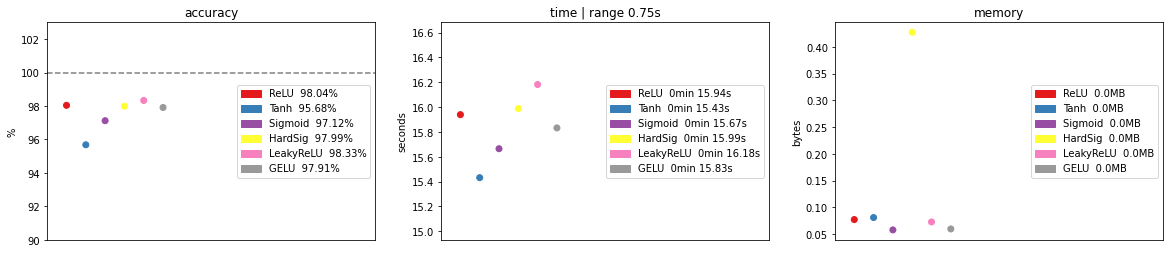

In [ ]:
print(f'Average results obtained for {repetition+1} repetition lasting {epochs} epochs')

all_acc2, all_time2, all_mem2 = results['acc'], results['time'], results['memory']

n = names.__len__()
x = range(n)

cols = plt.cm.Set1(numpy.linspace(0, 1, n))

plt.figure(figsize=(20, 4))
detached = 10

# accuracy
plt.subplot(131)
plt.axhline(y=100.0, linestyle='--', color='grey')
plt.scatter(x, all_acc2, c=x, cmap='Set1')
plt.xticks(())
plt.ylabel('%')
plt.ylim((90, 103))
plt.title('accuracy')
plt.xlim((-1, n+detached))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(all_acc2[h], 2))+'%'))
plt.legend(loc='right', handles=patches)


# time
plt.subplot(132)
plt.scatter(x, all_time2, c=x, cmap='Set1')
plt.xticks(())

plt.ylabel('seconds')
plt.xlim((-1, n+detached))
plt.ylim((numpy.min(all_time2)-0.5, max(all_time2)+0.5))

patches = []
for h, name in enumerate(names):
    min = round(all_time2[h]//60)
    sec = numpy.around(all_time2[h]%60, 2)
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(min)+'min '+str(sec)+'s'))
plt.legend(loc='right', handles=patches)
plt.title('time | range {}s'.format(numpy.around(max(all_time2)-numpy.min(all_time2), 2)))

# memory
plt.subplot(133)
plt.scatter(x, all_mem2, c=x, cmap='Set1')
plt.xticks(())
plt.title('memory')
plt.ylabel('bytes')
plt.xlim((-1, n+detached))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(all_mem2[h]/1048576, 4))+'MB'))
plt.legend(loc='right', handles=patches);

# EVALUATING BNN vs CNN
evaluation metrics are the same:
- accuracy
- time 
- memory 

In [ ]:
''' running the BNN '''

# simulation parameters
repetition = 0
epochs = 1

# activation function
act_func1 = (nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.Hardsigmoid(), nn.LeakyReLU(), nn.GELU())
names = ('ReLU', 'Tanh', 'Sigmoid', 'HardSig', 'LeakyReLU', 'GELU')

n = act_func1.__len__()

# dictionary describing the results obtained from each element
func_dictB = {}
for j, name in enumerate(act_func1):
    func_dictB[j] = {'name': str(name),
                    'func': name,
                    'acc': [],
                    'memory': [], 
                    'time': []}

# defining the order
order = numpy.arange(act_func1.__len__())
order_plus = numpy.random.choice(order, size=n, replace=False)
for _ in range(repetition):
    order_plus = numpy.concatenate((order_plus, numpy.random.choice(order, size=n, replace=False)))
numpy.random.shuffle(order_plus)
print('activation function order: ', order_plus)


for i, k in enumerate(order_plus):
    print(f'{i+1}|{order_plus.__len__()}, completed: {round(i/order_plus.__len__()*100)}%')
    # select
    func = func_dictB[k]['func']

    # run
    a, m, t, _, _, _, _, _ = generate2(act_fu=func)

    #store
    func_dictB[k]['acc'].append(a)
    func_dictB[k]['memory'].append(m)
    func_dictB[k]['time'].append(t)

print('\nBNN process terminated\n')
print('-'*50)

''' results '''
resultsB = {'acc': [],
           'memory': [],
           'time': []}

for j in order:
    for feature in ('acc', 'memory', 'time'):
        func_dictB[j][feature] = numpy.mean(func_dictB[j][feature])
        resultsB[feature].append(func_dictB[j][feature])


#################################################################################################################################################


''' CNN '''


# dictionary describing the results obtained from each element
func_dictC = {}
for j, name in enumerate(act_func1):
    func_dictC[j] = {'name': str(name),
                    'func': name,
                    'acc': [],
                    'memory': [], 
                    'time': []}


# RUN
for i, k in enumerate(order_plus):
    print(f'{i+1}|{order_plus.__len__()}, completed: {round(i/order_plus.__len__()*100)}%')

    # select
    func = func_dictC[k]['func']

    # actual run
    a, m, t, _, _, _, _, _ = generate_standard(act_fu=func)

    #store
    func_dictC[k]['acc'].append(a)
    func_dictC[k]['memory'].append(m)
    func_dictC[k]['time'].append(t)

print('both process terminated')


''' results '''
resultsC = {'acc': [],
           'memory': [],
           'time': []}

for j in order:
    for feature in ('acc', 'memory', 'time'):
        func_dictC[j][feature] = numpy.mean(func_dictC[j][feature])
        resultsC[feature].append(func_dictC[j][feature])
    

activation function order:  [0 2 5 4 1 3]
1|6, completed: 0%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: volatile was removed and now has no effect. Use `with torch.no

2|6, completed: 17%
3|6, completed: 33%
4|6, completed: 50%
5|6, completed: 67%
6|6, completed: 83%
BNN process terminated
1|6, completed: 0%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:163: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:193: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


2|6, completed: 17%
3|6, completed: 33%
4|6, completed: 50%
5|6, completed: 67%
6|6, completed: 83%
both process terminated


# 2 ALL-BINARY models

###NETWORK 3: **FULLY BINARY**

new LeNet-5, same as before (for XNOR-net) but where all the layers are binary



In [ ]:
class LeNet_5_fullB(nn.Module):
    def __init__(self, act_func):
        super(LeNet_5_fullB, self).__init__()
      
        self.bin_conv1 = BinConv2d(1, 20, kernel_size=5, stride=1, padding=0, 
                                  dropout=0, act_function=act_func)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bin_conv2 = BinConv2d(20, 50, kernel_size=5, stride=1,
                                   padding=0, dropout=0, act_function=act_func) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bin_ip1 = BinConv2d(50 * 4 * 4, 500, Linear=True,  
                                 previous_conv=True, size=4 * 4, act_function=act_func)

        self.bin_ip2 = BinConv2d(500, 10, Linear=True, 
                                 previous_conv=False, size=4 * 4, act_function=act_func,
                                 act_final=False, batchnorm=False)

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if hasattr(m.weight, 'data'):
                    m.weight.data.zero_().add_(1.0)
        return

    @staticmethod
    def forward(x, modules, bin_conv1, pool1, bin_conv2, pool2, bin_ip1, bin_ip2):
        for m in modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if hasattr(m.weight, 'data'):
                    m.weight.data.clamp_(min=0.01)

        x = bin_conv1(x, bn=bin_conv1.bn, dropout_ratio=bin_conv1.dropout_ratio, dropout=0,
                              Linear=bin_conv1.Linear, conv=bin_conv1.conv, previous_conv=bin_conv1.previous_conv,
                              input_channels=bin_conv1.input_channels, linear=0, relu=bin_conv1.relu)
        x = pool1(x)

        x = bin_conv2.forward(x, bn=bin_conv2.bn, dropout_ratio=bin_conv2.dropout_ratio, dropout=0,
                              Linear=bin_conv2.Linear, conv=bin_conv2.conv, previous_conv=bin_conv2.previous_conv,
                              input_channels=bin_conv2.input_channels, linear=0, relu=bin_conv2.relu)
        x = pool2(x)

        x = bin_ip1(x, bn=bin_ip1.bn, dropout_ratio=bin_ip1.dropout_ratio, dropout=0,
                    Linear=bin_ip1.Linear, conv=0, previous_conv=bin_ip1.previous_conv,
                    input_channels=bin_ip1.input_channels, linear=bin_ip1.linear, relu=bin_ip1.relu)
        
        x = bin_ip2(x, bn=bin_ip2.bn, dropout_ratio=bin_ip2.dropout_ratio, dropout=0,
                    Linear=bin_ip2.Linear, conv=0, previous_conv=bin_ip2.previous_conv,
                    input_channels=bin_ip2.input_channels, linear=bin_ip2.linear, relu=bin_ip2.relu)

        return x


### **Stochastic Binarization class**
modification of the original BinOp class defined by the authors

In [ ]:
class BinOp2():
    def __init__(self, model):
        # count the number of Conv2d and Linear
        count_targets = 0
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                count_targets = count_targets + 1  # count the number of layers

        start_range = 1
        end_range = count_targets - 2
        self.bin_range = numpy.linspace(start_range,
                                        end_range, end_range - start_range + 1) \
            .astype('int').tolist()
        self.num_of_params = len(self.bin_range)
        self.saved_params = []
        self.target_modules = []
        index = -1
        for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):  # save the parameters of the target layers
                index = index + 1
                if index in self.bin_range:
                    tmp = m.weight.data.clone()
                    self.saved_params.append(tmp)
                    self.target_modules.append(m.weight)
                    
        
        
        return

    def binarization(self):
        self.meancenterConvParams()
        self.clampConvParams()
        self.save_params()
        self.binarizeConvParams()

    def meancenterConvParams(self):
        for index in range(self.num_of_params):
            s = self.target_modules[index].data.size()  # size of the layer
            negMean = self.target_modules[index].data.mean(1, keepdim=True). \
                mul(-1).expand_as(self.target_modules[index].data)  # vector with the negative mean
            self.target_modules[index].data = self.target_modules[index].data.add(negMean)  # application to the layer

    def clampConvParams(self):  # clipping
        for index in range(self.num_of_params):
            self.target_modules[index].data = \
                self.target_modules[index].data.clamp(-1.0, 1.0)

    def save_params(self):  # save the mean centered real-clipped parameters
        for index in range(self.num_of_params):
            self.saved_params[index].copy_(self.target_modules[index].data)

    def binarizeConvParams(self):  # normalize and binarize
        for index in range(self.num_of_params):
            n = self.target_modules[index].data[0].nelement()
            s = self.target_modules[index].data.size()
            if len(s) == 4:
                m = self.target_modules[index].data.norm(1, 3, keepdim=True) \
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n)
            elif len(s) == 2:
                m = self.target_modules[index].data.norm(1, 1, keepdim=True).div(n)
            self.target_modules[index].data = self.stochastic(idx=index).mul(m.expand(s))

    def restore(self):
        for index in range(self.num_of_params):
            self.target_modules[index].data.copy_(self.saved_params[index])
            
    def stochastic(self, idx):
        p = torch.clip((self.target_modules[idx].data+1)/2, 0, 1)
        return torch.sign(torch.distributions.Binomial(1, p).sample()-0.5)

    def updateBinaryGradWeight(self):
        ''' 
        this correspond to the gradient manipulation:
        - clipping in (-1, +1)
        - backward BatchNormalization()
        '''
        for index in range(self.num_of_params):
            weight = self.target_modules[index].data
            n = weight[0].nelement()
            s = weight.size()

            # normalize -> weight norm (wnorm)
            if len(s) == 4:
                m = weight.norm(1, 3, keepdim=True) \
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)
            elif len(s) == 2:
                m = weight.norm(1, 1, keepdim=True).div(n).expand(s)

            # clip wnorm
            m[weight.lt(-1.0)] = 0
            m[weight.gt(1.0)] = 0

            # multiply wnorm by the gradient
            m = m.mul(self.target_modules[index].grad.data)

            # multiply the sign of the weights by the gradient -> signed grad vect
            m_add = weight.sign().mul(self.target_modules[index].grad.data)

            # sum grad vect
            if len(s) == 4:
                m_add = m_add.sum(3, keepdim=True) \
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)  # div: divide the tensor by args, expand: reshape
            elif len(s) == 2:
                m_add = m_add.sum(1, keepdim=True).div(n).expand(s)

            # mutiply sum grad vect by the weight sign
            m_add = m_add.mul(weight.sign())
            self.target_modules[index].grad.data = m.add(m_add).mul(1.0 - 1.0 / s[1]).mul(n)

            

### **model class**

In [ ]:
class Model_fullB:
    ''' 
    This is the network that comprehends LeNet5_2 full binary and some attributes to help training.
    It can have either a deterministic or stochastic binarization function
    
    '''
    
    def __init__(self, act_fun=nn.ReLU(), bin_op=BinOp):
        
        # model
        self.model = LeNet_5_fullB(act_func=act_fun)
        self.model.cuda()
        
        # parameters
        param_dict = dict(self.model.named_parameters())
        params = []
    
        # learning rate
        base_lr = 0.1
        self.lr = lr
    
        for key, value in param_dict.items():
            params += [{'params':[value], 'lr': lr,
                'weight_decay': weight_decay,
                'key':key}]

        # define optimization settings
        base_lr = 0.1
        self.optimizer = optim.Adam(params, lr=lr,
                            weight_decay=weight_decay)
        self.criterion = nn.CrossEntropyLoss()
        
        # define the binarization operator
        self.bin_op = bin_op(self.model)

    def training(self):
        self.model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            # input batch loading
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            self.optimizer.zero_grad()

            # process the weights including binarization
            self.bin_op.binarization()

            # forward
            output = self.model.forward(x=data, modules=self.model.modules, 
                                    bin_conv1=self.model.bin_conv1, pool1=self.model.pool1, 
                                    bin_conv2=self.model.bin_conv2, pool2=self.model.pool2, 
                                    bin_ip1=self.model.bin_ip1, 
                                    bin_ip2=self.model.bin_ip2)

            # backward
            loss = self.criterion(output, target)
            loss.backward()

            # restore weights
            self.bin_op.restore()

            # update
            self.bin_op.updateBinaryGradWeight()

            self.optimizer.step()

        return numpy.around(loss.data.item(), 3)


    def test(self, rec=False):
        
        if rec:
            with torch.no_grad():
                test_loss = 0
                correct = 0
                
                self.bin_op.binarization()
                
                t0 = time.time()
                tracemalloc.start()
                for data, target in test_loader:
                    if cuda:
                        data, target = data.cuda(), target.cuda()
                    data, target = Variable(data), Variable(target)
                    output = self.model.forward(data, modules=self.model.modules, 
                                        bin_conv1=self.model.bin_conv1, pool1=self.model.pool1, 
                                        bin_conv2=self.model.bin_conv2, pool2=self.model.pool2, 
                                        bin_ip1=self.model.bin_ip1, 
                                        bin_ip2=self.model.bin_ip2)

                    test_loss += self.criterion(output, target).data.item()
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

                
                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                tim_used = time.time() - t0
                
                # self.bin_op.restore()
                best_acc = 100. * float(correct) / len(test_loader.dataset)
        
            test_loss /= len(test_loader.dataset)
            
        
            return best_acc, current/1024/1024, tim_used
  
        with torch.no_grad():
            test_loss = 0
            correct = 0

            self.bin_op.binarization()
            for data, target in test_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                output = self.model.forward(data, modules=self.model.modules, 
                                    bin_conv1=self.model.bin_conv1, pool1=self.model.pool1, 
                                    bin_conv2=self.model.bin_conv2, pool2=self.model.pool2, 
                                    bin_ip1=self.model.bin_ip1, 
                                    bin_ip2=self.model.bin_ip2)
                
                test_loss += self.criterion(output, target).data.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            self.bin_op.restore()

            best_acc = 100. * float(correct) / len(test_loader.dataset)
        
        test_loss /= len(test_loader.dataset)
        
        return best_acc
    
    
    def long_test(self):
        
        with torch.no_grad():
            test_loss = 0
            correct = 0

            self.bin_op.binarization()

            t0 = time.time()
            tracemalloc.start()
            for data, target in train_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                output = self.model.forward(data, modules=self.model.modules, 
                                    bin_conv1=self.model.bin_conv1, pool1=self.model.pool1, 
                                    bin_conv2=self.model.bin_conv2, pool2=self.model.pool2, 
                                    bin_ip1=self.model.bin_ip1, 
                                    bin_ip2=self.model.bin_ip2)

                test_loss += self.criterion(output, target).data.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()


            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            tim_used = time.time() - t0

            # self.bin_op.restore()
            best_acc = 100. * float(correct) / len(test_loader.dataset)

        test_loss /= len(test_loader.dataset)

        return current/1024/1024, tim_used

    def adjust_learning_rate(self, epoch):
        """Sets the learning rate to the initial LR decayed by 10 every 15 epochs"""
        self.lr = self.lr * (0.1 ** (epoch // lr_epochs))
        #print('Learning rate:', lr)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr


###################################################################################################################################


def generate_fullB_det(act_fu, show=False, bin_op=BinOp):
    
    ''' compact run fully binary BNN - deterministic binarization '''

    # model
    name = str(act_fu)[:-2]
    network = Model_fullB(act_fun=act_fu, bin_op=bin_op)

    # states
    best_acc = 0.0
    accs = []
    losses = []
    
    # start measure
    gc.collect()
    time0 = time.time()
    tracemalloc.start()
    
    # run
    for epoch in range(1, epochs + 1):

        network.adjust_learning_rate(epoch)
        loss_ = network.training()
        acc_ = network.test()

        # state
        accs.append(acc_)
        losses.append(loss_)


        if show:
            # plots
            plt.clf()
            plt.figure(figsize=(15, 4))

            plt.subplot(121)
            plt.axhline(y=100.0, linestyle='--', color='grey')
            plt.plot(range(epoch), accs, label=f'accuracy {accs[-1]}')
            plt.title('Test Accuracy  - type: {} - epoch {}|{}'.format(name, epoch, epochs))
            plt.legend()
            plt.xlabel('epochs')
            plt.ylabel('%')
            plt.xlim((0, epochs-1))
            plt.ylim((80, 110))

            plt.subplot(122)
            plt.plot(range(epoch), losses, label=f'loss {losses[-1]}')
            plt.title('loss')
            plt.xlabel('epochs')
            plt.legend()
            plt.xlim((0, epochs-1))

            plt.pause(0.000001)

            if is_ipython: display.clear_output(wait=True)


    # end measure
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    timeU = time.time() - time0

    # logs
    a, m, t = network.test(rec=True)
    
    m2, t2 = network.long_test()
    
    # return: training accuracy, training memory, training time,
    #         test accuracy, test memory, test time,
    #         long test memory, long test time
    return accs[-1], current/1024/1024, timeU, a, m, t, m2, t2


###################################################################################################################################


def generate_fullB_stoch(act_fu, show=False, bin_op=BinOp2):
    
    ''' compact run fully binary BNN - stochastic binarization '''

    # model
    name = str(act_fu)[:-2]
    network = Model_fullB(act_fun=act_fu, bin_op=bin_op)

    # logs
    best_acc = 0.0
    accs = []
    losses = []
    
    # start measure
    gc.collect()
    time0 = time.time()
    tracemalloc.start()
    
    # run
    for epoch in range(1, epochs + 1):

        network.adjust_learning_rate(epoch)
        loss_ = network.training()
        acc_ = network.test()

        # state
        accs.append(acc_)
        losses.append(loss_)


        if show:
            # plots
            plt.clf()
            plt.figure(figsize=(15, 4))

            plt.subplot(121)
            plt.axhline(y=100.0, linestyle='--', color='grey')
            plt.plot(range(epoch), accs, label=f'accuracy {accs[-1]}')
            plt.title('Test Accuracy  - type: {} - epoch {}|{}'.format(name, epoch, epochs))
            plt.legend()
            plt.xlabel('epochs')
            plt.ylabel('%')
            plt.xlim((0, epochs-1))
            plt.ylim((80, 110))

            plt.subplot(122)
            plt.plot(range(epoch), losses, label=f'loss {losses[-1]}')
            plt.title('loss')
            plt.xlabel('epochs')
            plt.legend()
            plt.xlim((0, epochs-1))

            plt.pause(0.000001)

            if is_ipython: display.clear_output(wait=True)


    # end measure
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    timeU = time.time() - time0
    
    # logs
    a, m, t = network.test(rec=True)
    
    m2, t2 = network.long_test()

    # return: training accuracy, training memory, training time,
    #         test accuracy, test memory, test time,
    #         long test memory, long test time
    return accs[-1], current/1024/1024, timeU, a, m, t, m2 , t2

### Quick Run

*long test memory usage across the 4 models*

test the functionality of all four functions

In [ ]:
epoch = 1

for i, run in enumerate(generate2, generate_fullB_det, generate_fullB_stoch, generate_cnn):
    _, _, _, _, _, _, _, m = run(act_fu=nn.ReLU())
    print(f'model {i}\nmemory: {m:.3f}KB')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: volatile was removed and now has no effect. Use `with torch.no

model: <function generate2 at 0x7faf2e189488>
memory: 12.488655090332031KB
model: <function generate_fullB_det at 0x7faeee036510>
memory: 12.978893995285034KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)


model: <function generate_fullB_stoch at 0x7faeeab1d0d0>
memory: 12.874427318572998KB
model: <function generate_cnn at 0x7faeea563598>
memory: 13.12355089187622KB


run: 0|2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:300.)


run: 1|2


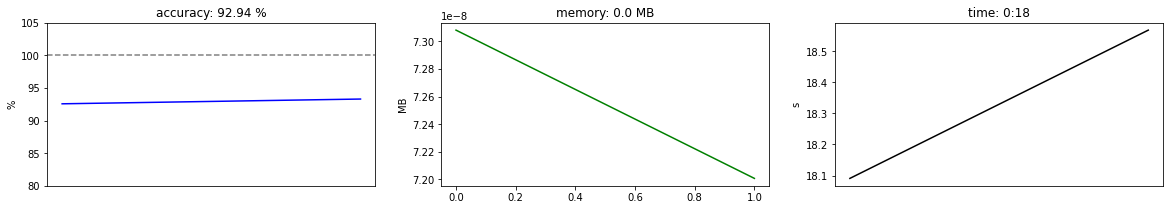

In [ ]:
## bag of run
n_run = 2
epochs = 1
A = []
M = []
T = []
for i in range(n_run):
    print(f'run: {i}|{n_run}')
    a, m, t, _, _, _, _, _ = generate_fullB_det(act_fu=nn.Tanh(), show=False)
    A.append(a)
    M.append(m/1024/1024)
    T.append(t)

plt.figure(figsize=(20, 3))

plt.subplot(131)
plt.axhline(y=100, linestyle='--', color='grey')
plt.plot(range(n_run), A, '-b')
plt.title(f'accuracy: {numpy.around(numpy.mean(A), 2)} %')
plt.ylim((80, 105))
plt.ylabel('%')
plt.xticks(())

plt.subplot(132)
plt.plot(range(n_run), M, '-g')
plt.title(f'memory: {numpy.around(numpy.mean(M), 3)} MB')
plt.ylabel('MB')
plt.xticks()

plt.subplot(133)
plt.plot(range(n_run), T, '-k')
plt.title(f'time: {int(numpy.mean(T)//60)}:{int(numpy.mean(T)%60)}')
plt.ylabel('s')
plt.xticks(());

# Big Simulation: normal BNN, full BNN, stochastic BNN, standard CNN
comparison of all four models, same metrics measured for training, testing and long testing

#### function for averaging over n runs


In [ ]:
def avg_of_run(gen, act_fu=nn.Tanh(), nom=0):

    # training values
    A = []
    M = []
    T = []
    
    # test values
    At = []
    Mt = []
    Tt = []
    
    # long test values
    Mt2 = []
    Tt2 = []
    
    # run for n times and record the logs
    for i in range(n_run):
        a, m, t, at, mt, tt, at2, tt2 = gen(act_fu=act_fu)
        A.append(a)
        M.append(m)
        T.append(t)
        
        At.append(at)
        Mt.append(mt)
        Tt.append(tt)
        
        Mt2.append(at2)
        Tt2.append(tt2)
        
    # return the mean values of all the metrics over the n runs
    return numpy.around(numpy.mean(A), 3), numpy.around(numpy.mean(M), 3), numpy.mean(T), numpy.around(numpy.mean(At), 3), numpy.around(numpy.mean(Mt), 3), numpy.mean(Tt), numpy.mean(Mt2), numpy.mean(Tt2)
    

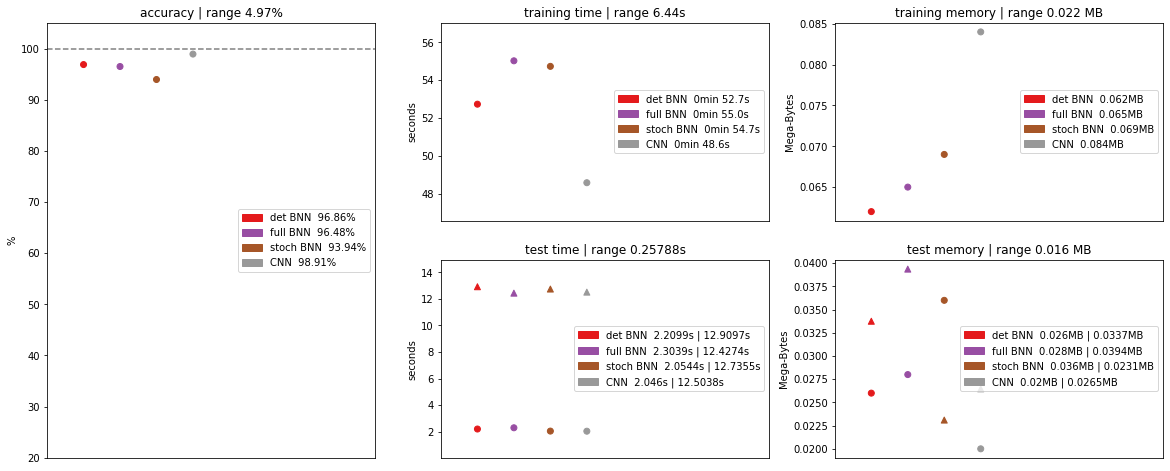

In [ ]:
# simulation settings
n_run = 1
epochs = 3

# logs
acc = []
memory = []
tim = []

accT = []
memoryT = []
timT = []

memoryT2 = []
timT2 = []

# simulation logs
tperiod = 0
testm = 0

for k, gen_function in enumerate((generate2, generate_fullB_det, generate_fullB_stoch, generate_cnn)): 
    tstart = time.time()
    print(f'current: {k+1}|4 - last duration: {round(tperiod//60)}min {round(tperiod%60)}s - estimated finish: {round(testm//60)}min {round(testm%60)}s')
    a0, m0, t0, a1, m1, t1, m2, t2 = avg_of_run(gen=gen_function, act_fu=nn.ReLU(), nom=k)
    acc.append(a0)
    memory.append(m0)
    tim.append(t0)
    
    accT.append(a1)
    memoryT.append(m1)
    timT.append(t1)
    
    memoryT2.append(m2)
    timT2.append(t2)
    
    if is_ipython: display.clear_output(wait=True)
    tperiod = time.time() - tstart
    testm = tperiod * (3-k)

    print('\nprocess terminated')

plots

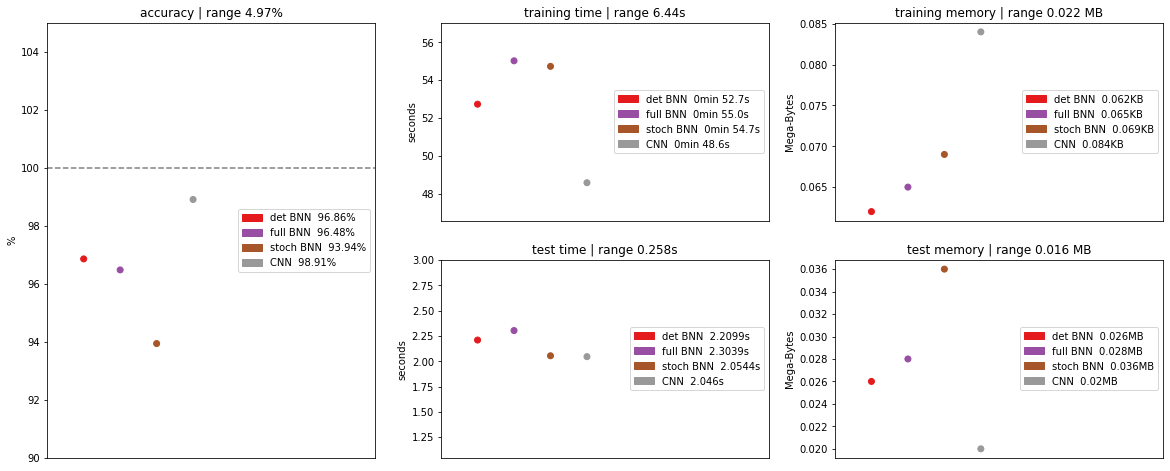


for the TEST:
     dot ------> test set (short)
     triangle -> training set (long)


In [ ]:
##############################################################################################################################

all_acc, all_time, all_mem = acc, tim, memory

names = ('det BNN', 'full BNN', 'stoch BNN', 'CNN')
n = names.__len__()
x = range(n)

cols = plt.cm.Set1(numpy.linspace(0, 1, n))

plt.figure(figsize=(20, 8))
detached = 4

# accuracy
plt.subplot(131)
plt.axhline(y=100.0, linestyle='--', color='grey')
plt.scatter(x, all_acc, c=x, cmap='Set1')
plt.xticks(())
plt.ylabel('%')
plt.ylim((90, 105))
plt.title(f'accuracy | range {numpy.around(max(all_acc) - numpy.min(all_acc), 2)}%')
plt.xlim((-1, n+detached))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(all_acc[h], 2))+'%'))
plt.legend(loc='right', handles=patches)


# time
plt.subplot(232)
plt.scatter(x, all_time, c=x, cmap='Set1')
plt.xticks(())

plt.ylabel('seconds')
plt.xlim((-1, n+detached))
plt.ylim((numpy.min(all_time)-2, max(all_time)+2))

patches = []
for h, name in enumerate(names):
    min = round(all_time[h]//60)
    sec = numpy.around(all_time[h]%60, 1)
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(min)+'min '+str(sec)+'s'))
plt.legend(loc='right', handles=patches)
plt.title('training time | range {}s'.format(numpy.around(max(all_time)-numpy.min(all_time), 2)))

# memory
plt.subplot(233)
plt.scatter(x, all_mem, c=x, cmap='Set1')
plt.xticks(())
plt.title(f'training memory | range {numpy.around(max(all_mem) - numpy.min(all_mem), 4)} MB')
plt.ylabel('Mega-Bytes')
plt.xlim((-1, n+detached))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(all_mem[h], 4))+'KB'))
plt.legend(loc='right', handles=patches)



########## test ##########

# time
plt.subplot(235)
plt.scatter(x, timT, c=x, cmap='Set1')
#plt.scatter(x, timT2, c=x, marker='^', cmap='Set1')
plt.xticks(())

plt.ylabel('seconds')
plt.xlim((-1, n+detached))
plt.ylim((numpy.min((numpy.min(timT2), numpy.min(timT)))-1, 3))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(timT[h]%60, 4))+'s'))
plt.legend(loc='right', handles=patches)
plt.title('test time | range {}s'.format(numpy.around(max(timT)-numpy.min(timT), 3)))


# memory
plt.subplot(236)
plt.scatter(x, memoryT, c=x, cmap='Set1')
#plt.scatter(x, memoryT2, c=x, marker='^', cmap='Set1')
plt.xticks(())
plt.title(f'test memory | range {numpy.around(max(memoryT) - numpy.min(memoryT), 3)} MB')
plt.ylabel('Mega-Bytes')
plt.xlim((-1, n+detached))

patches = []
for h, name in enumerate(names):
    patches.append(mpatches.Patch(color=cols[h], label=name+'  '+str(numpy.around(memoryT[h], 4))+'MB'))
plt.legend(loc='right', handles=patches)

plt.show()
print('\nfor the TEST:\n     dot ------> test set (short)\n     triangle -> training set (long)')